## 1. 필요한 패키지 불러오기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import glob
from PIL import Image, ImageColor
import random
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
import imgaug as ia
import imgaug.augmenters as iaa
from copy import deepcopy
from utils import load_data, imgaug
from sklearn.metrics import classification_report, confusion_matrix

## 2. 데이터 경로에 맞게 데이터 가져오기

### 2.1 데이터 가져오기

In [2]:
data_paths = ["./data/cropped_rps/*"]
width, height = 224, 224
x_data, y_data = load_data(data_paths)
print(f"x_data shape : {x_data.shape}\t y_data shape : {y_data.shape}")

x_data shape : (300, 224, 224, 3)	 y_data shape : (300, 1)


### 2.2 가져온 데이터 확인하기

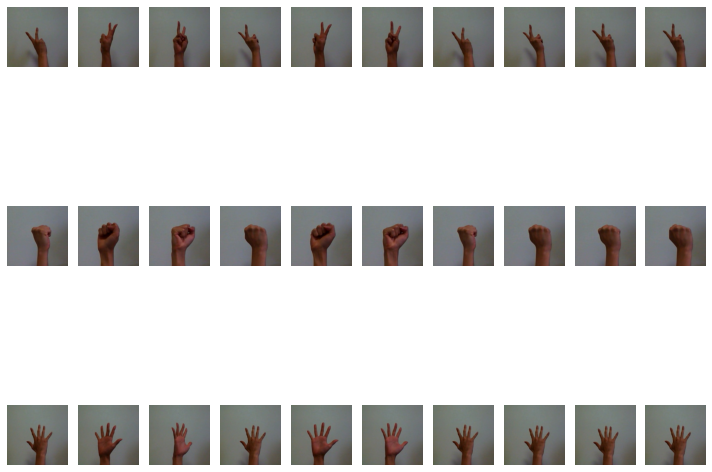

In [3]:
fig, axes = plt.subplots(3, 10, figsize=(10,10))
axes = axes.ravel()
ex1 = x_data[(y_data == 0).reshape(-1)][:10]
ex2 = x_data[(y_data == 1).reshape(-1)][:10]
ex3 = x_data[(y_data == 2).reshape(-1)][:10]

ex = np.concatenate([ex1,ex2,ex3], axis=0)

for i, ax in enumerate(axes):
    ax.imshow(ex[i])
    ax.axis("off")
plt.tight_layout()
plt.show()

### 2.3 데이터 증강(TODO : [케라스 데이터 증강](https://keras.io/ko/preprocessing/image/))

#### 2.3.1 데이터 증강 적용

In [28]:
#ia.seed(300)
cp_x_data = deepcopy(x_data)
cp_y_data = deepcopy(y_data)
for i in range(5):
    aug_x_data = imgaug(cp_x_data) # augmentation 적용된 이미지들
    x_data = np.concatenate([x_data, aug_x_data], axis=0)
    y_data = np.concatenate([y_data, cp_y_data], axis=0)
    print(f"{i+1}번째 완료\tx_data shape : {x_data.shape}\ty_data shape : {y_data.shape}")

1번째 완료	x_data shape : (600, 224, 224, 3)	y_data shape : (600, 1)
2번째 완료	x_data shape : (900, 224, 224, 3)	y_data shape : (900, 1)
3번째 완료	x_data shape : (1200, 224, 224, 3)	y_data shape : (1200, 1)
4번째 완료	x_data shape : (1500, 224, 224, 3)	y_data shape : (1500, 1)
5번째 완료	x_data shape : (1800, 224, 224, 3)	y_data shape : (1800, 1)


#### 2.3.2 데이터 정규화 및 순서 섞기

In [29]:
x_data = x_data / 255

np.random.seed(3)
np.random.shuffle(x_data)
np.random.seed(3)
np.random.shuffle(y_data)

#### 2.3.3 데이터 증강 결과 비교하기

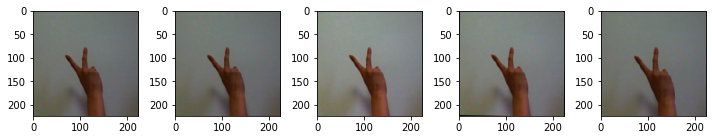

In [5]:
fig, ax = plt.subplots(1,5, figsize=(10,10))
try:
    ax[0].imshow(x_data[0])
    ax[1].imshow(x_data[300])
    ax[2].imshow(x_data[600])
    ax[3].imshow(x_data[1200])
    ax[4].imshow(x_data[1500])
except:
    pass

plt.tight_layout()
plt.show()

## 3. 모델 구축하기

In [42]:
def create_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3,3), activation='relu', padding = "same",input_shape=(width, height, 3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding = "same"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    return model

## 4. 모델 학습하기

In [52]:
# 교차 검증 준비
k = 3
# kfold 자체 shuffle은 기능이 별로인듯 합니다.
strat_kfold = StratifiedKFold(n_splits = k)
result_acc = []
result_loss = []

# 콜백 준비
# es = EarlyStopping(monitor="val_loss", mode = "min", patience = 2)
# cp = ModelCheckpoint(filepath="./models/rock_paper_scissors/rps_model.h5",
#                     monitor='val_loss', 
#                     verbose=0, 
#                     save_best_only=True, 
#                     mode='min')

# k-fold 검증이 적용된 학습 시작
for train_index, val_index  in strat_kfold.split(x_data, y_data):
    
    model = create_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_data[train_index], 
              y_data[train_index], 
              epochs = 2, 
              verbose = 1
             )
    val_loss, val_acc = model.evaluate(x_data[val_index], 
                                       y_data[val_index], 
                                       verbose = 1)
    
    result_acc.append(val_acc)
    result_loss.append(val_loss)

print(f"{k}-fold 평균 acc : {sum(result_acc) / len(result_acc)}")
print(f"{k}-fold 평균 loss : {sum(result_loss) / len(result_loss)}")

Epoch 1/2
38/38 [==============================] - 2s 42ms/step - loss: 1.4885 - accuracy: 0.4105
Epoch 2/2
19/19 [==============================] - 0s 17ms/step - loss: 0.1540 - accuracy: 0.9550
Epoch 1/2
38/38 [==============================] - 2s 42ms/step - loss: 2.5125 - accuracy: 0.3035
Epoch 2/2
19/19 [==============================] - 0s 17ms/step - loss: 0.4633 - accuracy: 0.8667
Epoch 1/2
38/38 [==============================] - 2s 42ms/step - loss: 1.8093 - accuracy: 0.3986
Epoch 2/2
19/19 [==============================] - 0s 17ms/step - loss: 0.1439 - accuracy: 0.9667
3-fold 평균 acc : 0.929444432258606
3-fold 평균 loss : 0.2537236511707306


## 6. 모델 성능 검증하기

### 6.1 테스트셋 가져오기

In [4]:
test_paths = ["./data/rps_kimseong/*"]
x_test, y_test = load_data(test_paths)
print(f"x_test shape : {x_test.shape}\t y_test shape : {y_test.shape}")
x_test = x_test / 255

x_test shape : (300, 224, 224, 3)	 y_test shape : (300, 1)


#### 6.1.1 훈련셋, 테스트셋 비교하기

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


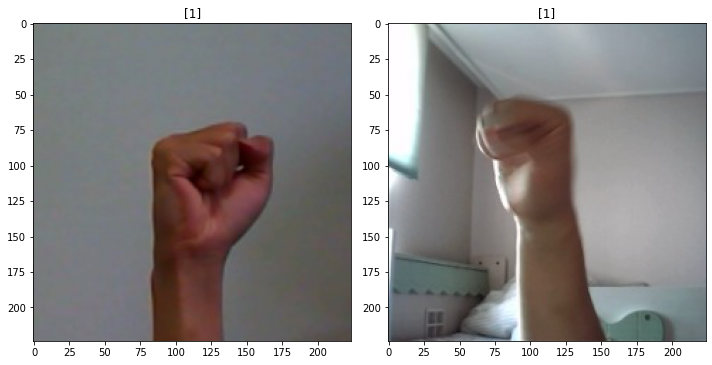

In [5]:
i = np.random.randint(0,len(x_test))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(x_data[i])
ax[0].set_title(y_data[i])

ax[1].imshow(x_test[i])
ax[1].set_title(y_test[i])

plt.tight_layout()
plt.show()

### 6.2 테스트셋 예측 결과 확인하기

In [6]:
# model.save("./models/rock_paer_scissors/best_model.h5")
model = keras.models.load_model("./models/rock_paper_scissors/best_model_69.h5")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("test_accuracy: {}".format(test_accuracy))
print("test_loss: {} ".format(test_loss))

10/10 [==============================] - 4s 132ms/step - loss: 0.7885 - accuracy: 0.6967
test_accuracy: 0.6966666579246521
test_loss: 0.7884802222251892 


In [7]:
y_pred = model.predict(x_test).argmax(axis=1)
y_true = y_test
score = 0

for i in range(len(y_true)):
    if y_pred[i] == y_true[i]:
        score += 1
score = round((score / len(y_true)) * 100, 2)
print(f"테스트 데이터에서의 모델 정확성 : {score}%")

테스트 데이터에서의 모델 정확성 : 69.67%


In [8]:
print(confusion_matrix(y_true, y_pred))

[[88  0 12]
 [ 9 91  0]
 [51 19 30]]


In [9]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.88      0.71       100
           1       0.83      0.91      0.87       100
           2       0.71      0.30      0.42       100

    accuracy                           0.70       300
   macro avg       0.71      0.70      0.67       300
weighted avg       0.71      0.70      0.67       300



## 7. 예측 결과 살펴보기

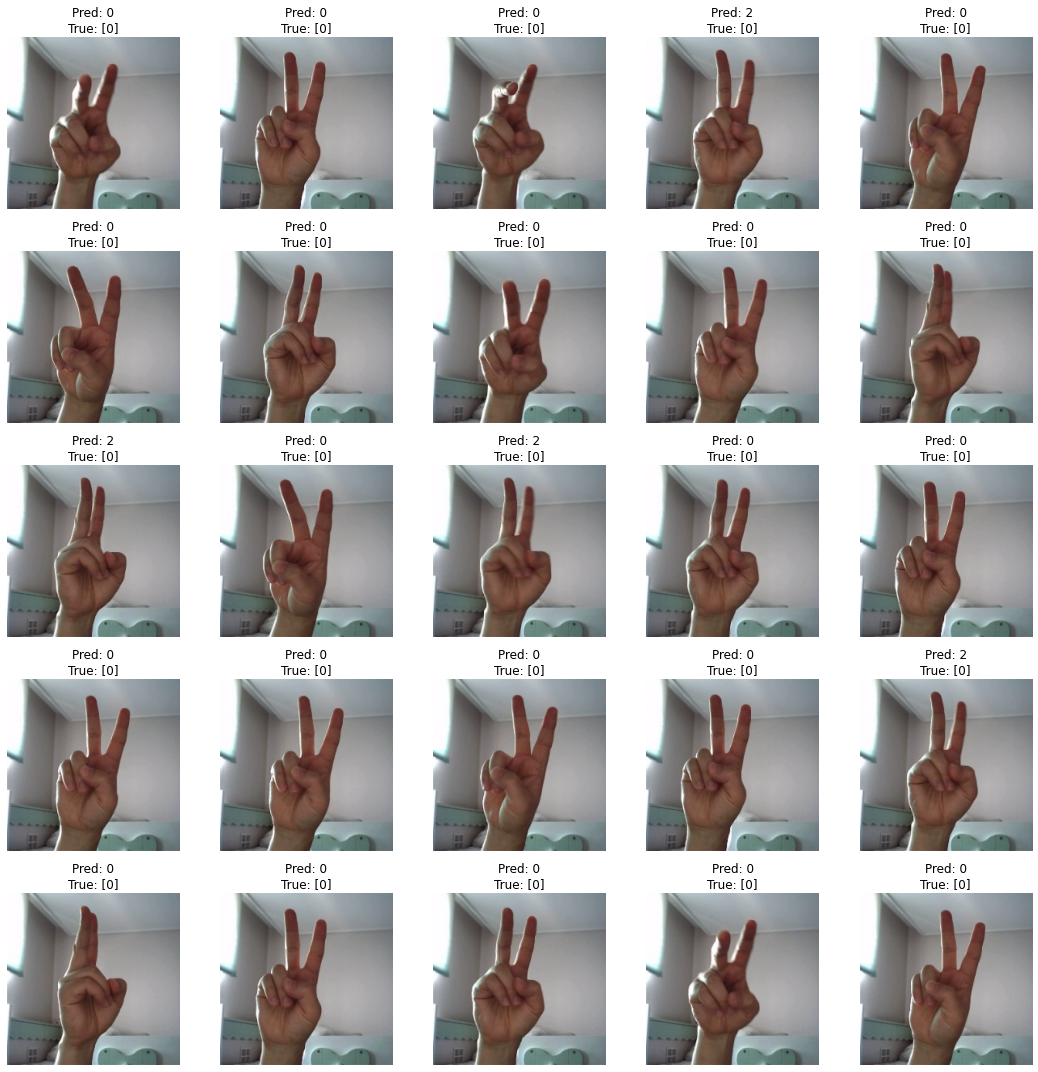

In [10]:
# graph_n2 = round(np.sqrt(len(y_data2)))
graph_n2 = 5
fig2, axes2 = plt.subplots(graph_n2, graph_n2, figsize = (15, 15))
axes2 = axes2.ravel()

for ind, axis in enumerate(axes2):
    axis.imshow(x_test[ind])
    axis.set_title(f"Pred: {y_pred[ind]}\nTrue: {y_true[ind]}")
    axis.axis("off")
    
plt.tight_layout()
plt.show()